# Sentiment Analysis of Movie Reviews using scikit-learn

In this notebook, I perform sentiment analysis of movie reviews using `scikit-learn`.

The dataset consists of 50k highly polarized (*clearly* favourable or unfavourable) movie reviews from IMBD. The set is partitioned into a labelled train set of 25k reviews and a labelled test set of 25k reviews. The reviews are preprocessed by lower-casing, removing HTML tags, and removing punctutation. The reviews are then tokenized, removing English stop words, and stemmed. Corpus vectorization is implemented using `TfidfVectorizer`. Multiple classification models are trained and tested on the results. The best performing model is pickled for later deployment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Installs and Imports

In [ ]:
!pip install datasets

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import re

from nltk import PorterStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

from scipy.stats import loguniform, uniform
from string import punctuation
from datasets import load_dataset

## Load the IMDB Dataset

In [18]:
ds = load_dataset('imdb')
train, test = pd.DataFrame(ds['train']), pd.DataFrame(ds['test'])

In the following DataFrame samples, a label of 0 corresponds to a negative review (*i.e.,* thumbs-down) whereas a label of 1 corresponds to a positive review (*i.e.,* thumbs-up).

In [19]:
train.sample(5)

,text,label
5095,"The name of Nick Stahl, the young cast and the...",0
5455,Mirror. Mirror (1990) is a flat out lame movie...,0
4141,Man has been to the farthest reaches of the ea...,0
5992,POSSIBLE SPOILERS<br /><br />The Spy Who Shagg...,0
22542,"I must admit, when I read the description of t...",1


In [20]:
test.sample(5)

,text,label
9497,Old bat transforms to younger OK looking girl ...,0
8578,I really wish Hollywood would come up with som...,0
11523,Jim Brown stars and produces a tale set in the...,0
1981,This is one of the worst films I have seen in ...,0
18737,Centres on Czech WW2 pilots  the older Franti...,1


## Exploratory Data Analysis

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


I plot the distribution of movie review labels in the train set.

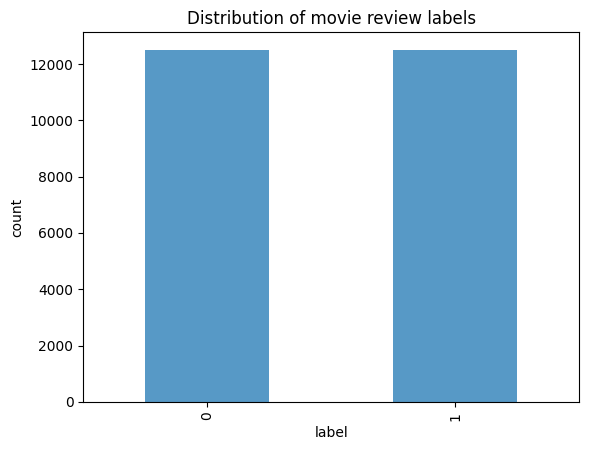

In [22]:
fig, ax = plt.subplots()
train.groupby('label').count().plot(kind='bar', alpha=0.75, ax=ax)
ax.set_ylabel('count')
ax.set_title('Distribution of movie review labels')
ax.legend().set_visible(False)
plt.show()

From the above bar graph, the train set appears to be balanced. To confirm:

In [23]:
train['label'].value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

It is instructive to read a handful of reviews to better understand what is meant by "highly polarized."

In [24]:
thumbs_ups = train[train['label'] == 1]
thumbs_downs = train[train['label'] == 0]

In [25]:
thumbs_up_samples = thumbs_ups['text'].sample(3).to_list()
print('\n\n'.join(thumbs_up_samples))

This movie is about a side of Ireland that Americans don't normally see, the narrow-minded religiously prejudiced side of the 'friendliest race in the world'. The movie, by the admission of the inhabitants of Fethard who are old enough to remember the events, is fairly accurate (though they insist that the film-makers invented some of the more violent scenes just to spice up the action).<br /><br />The movie was very unpopular in Ireland as it portrayed the Catholic church in a bad light, but the simple fact is that representatives of the Catholic church *did* organise vetoes of minorities (before Protestants it was the Jews).<br /><br />The film is a fascinating insight into the whole issue of religion in Ireland

Finally, an indie film that actually delivers some great scares! I see most horror films that come out... Theatrical, Straight-To-DVD, cable, etc... and most of them suck... a few are watchable... even fewer are actually good... Dark Remains is one of the good ones. I caught

In [26]:
thumbs_down_samples = thumbs_downs['text'].sample(3).to_list()
print('\n\n'.join(thumbs_down_samples))

I saw this director's "Woman On The Beach" and could not understand the good to great reviews. This film is much like that one, two people who are caught in a relationship with very little dynamic and even less interest to anyone else. Like his other films, you have to want to listen to vacuous dialog, wade through very little and become enchanted with underwritten, pretty uninteresting characters. If you feel you can like this film, don't let my review stop you. I do like minimalism in films, but I feel Tsai Ming-Liang's films are far superior. He has a fairly terrific actor in Lee Kang-Sheng in his films. There is nothing here. I wish IU liked it, but I don't. Oh, well.

I remember when I first saw this movie, I was in sixth grade when it happened. Before I saw this, i had listened to the original Broadway recording of it, and I really loved it! But when I saw this, I was like, what the heck?! This movie is missing a lot of the songs from the musical for crying out loud! Who decided 

## Preprocessor

The preprocessor transforms movie reviews by lower-casing, removing HTML tags, and removing punctuation.

In [27]:
class Preprocessor(BaseEstimator, TransformerMixin):
    @staticmethod
    def strip_html(X):
        """Remove HTML tags from a corpus X."""
        return [re.sub(r'<[^>]+>', ' ', doc) for doc in X]

    @staticmethod
    def strip_forward_slashes(X):
        """Replace / by a space in a corpus X."""
        return [doc.replace('/', ' ') for doc in X]

    @staticmethod
    def strip_punctuation(X):
        """
        Remove punctuation from a corpus X.
        """
        def strip_punc_from_doc(doc: str) -> str:
            """Remove punctuation from a single document doc."""
            doc_trans = doc
            for p in punctuation:
                doc_trans = doc_trans.replace(p, '')
            return doc_trans

        return [strip_punc_from_doc(doc) for doc in X]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            X = X.to_list()

        X_trans = X
        X_trans = [doc.lower() for doc in X_trans]
        X_trans = Preprocessor.strip_html(X_trans)
        X_trans = Preprocessor.strip_forward_slashes(X_trans)
        X_trans = Preprocessor.strip_punctuation(X_trans)

        return X_trans

To see Preprocessor in action, pick a random movie review:

In [28]:
preprocessor = Preprocessor()

doc = train['text'].sample()
doc_preprocessed = preprocessor.transform(doc)

print(doc.to_list()[0])
print()
print(doc_preprocessed[0])

If you ever watched the Dukes of Hazard you know that you never had to worry about drugs or cussing or crude behavior being seen by young children. If you've seen the movie you know that is no longer the case! This movie was HORRIBLE! Main characters doing drugs and thinking it is funny and cool is certainly not what I call entertainment. They took a wonderful show and just turned it into trash. Daisy who was a little flirtatious in the original show now looks and acts like she belongs on the street corner getting paid for her services. I was so excited about seeing this movie before it came out, 15 minutes into the movie I was ready to leave. I stayed thinking it had to get better but instead it got worse by the minute. I wish I had never seen this movie. It trashed a good show and left nothing but horrible taste in my mouth when I left. Do yourself a favor, go see something worth your money, cause it's not only a waste of money but a waste of 2 hours of your life you will never get b

## Tokenizer

The tokenizer removes English stop words and stems the corpus.

In [29]:
class Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, stemmer, stop_words=None):
        """
        Initialize a Tokenizer.

        :param stemmer: An instance of a word stemmer
        :param stop_words: A list of words to remove from the corpus
        """
        self.stemmer = stemmer
        self.stop_words = stop_words

    def remove_stop_words(self, X):
        """
        Remove stop words from a corpus X.
        """
        def remove_stop_words_from_doc(doc):
            """Remove stop words from a document doc."""
            doc_trans = []
            for word in doc:
                if word not in self.stop_words:
                    doc_trans.append(word)
            return doc_trans

        return [remove_stop_words_from_doc(doc) for doc in X]

    def stem(self, X):
        """
        Stem a corpus X.
        """
        def stem_doc(doc):
            """Stem a document doc."""
            return_doc = []
            for word in doc:
                return_doc.append(self.stemmer.stem(word))
            return return_doc

        return [stem_doc(doc) for doc in X]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            X = X.to_list()

        X_trans = X
        X_trans = [doc.split() for doc in X_trans]
        X_trans = self.remove_stop_words(X_trans)
        X_trans = self.stem(X_trans)
        X_trans = [' '.join(doc) for doc in X_trans]

        return X_trans

To see Tokenizer in action, transform the previously preprocessed movie review.

In [30]:
tokenizer = Tokenizer(PorterStemmer(), ENGLISH_STOP_WORDS)

doc_tokenized = tokenizer.transform(doc_preprocessed)

print(doc_preprocessed[0])
print()
print(doc_tokenized[0])

if you ever watched the dukes of hazard you know that you never had to worry about drugs or cussing or crude behavior being seen by young children if youve seen the movie you know that is no longer the case this movie was horrible main characters doing drugs and thinking it is funny and cool is certainly not what i call entertainment they took a wonderful show and just turned it into trash daisy who was a little flirtatious in the original show now looks and acts like she belongs on the street corner getting paid for her services i was so excited about seeing this movie before it came out 15 minutes into the movie i was ready to leave i stayed thinking it had to get better but instead it got worse by the minute i wish i had never seen this movie it trashed a good show and left nothing but horrible taste in my mouth when i left do yourself a favor go see something worth your money cause its not only a waste of money but a waste of 2 hours of your life you will never get back

watch duke

## Classifer

I train and test logistic regression, random forest, and support vector machine classifiers on the IMDB movie reviews. I score the models using F1-score because the train set is balanced and the consequences of misclassifying a positive review are the same as misclassifying a negative review.

In [31]:
X_train, X_test, y_train, y_test =\
    train['text'], test['text'], train['label'], test['label']

In [32]:
n_iter = 25  # num iterations per randomized grid search

### Logistic Regression

In [33]:
vectorizer = TfidfVectorizer(
    max_df = 0.95,
    min_df = 2,
    max_features = 10_000,
    strip_accents='unicode'
)

cleaner = Pipeline([
    ('preprocessor', Preprocessor()),
    ('tokenizer', Tokenizer(PorterStemmer(), ENGLISH_STOP_WORDS)),
    ('vectorizer', vectorizer)
])

In [34]:
lr = LogisticRegression(
    penalty='l2',
    solver='saga',
    max_iter=500
)

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', lr)
])

param_distributions = {
    'classifier__C': loguniform(1e-2, 1e2)
}

search_lr = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    refit=True
)

In [35]:
search_lr.fit(X_train, y_train);

In [36]:
test_score_lr = search_lr.score(X_test, y_test)

print(f'Best parameters: {search_lr.best_params_}')
print(f'F1-score: {test_score_lr}')

Best parameters: {'classifier__C': 0.8037855463158128}
F1-score: 0.8747107174207964


In [37]:
best_model = search_lr.best_estimator_
best_score = test_score_lr

### Random Forest

In [38]:
rfc = RandomForestClassifier()

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', rfc)
])

param_distributions = {
    'classifier__n_estimators': [10, 30, 100, 300, 1000],
    'classifier__max_depth': list(range(10, 101)),
    'classifier__min_samples_split': list(range(2, 11)),
    'classifier__min_samples_leaf': list(range(1, 11))
}

search_rfc = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    refit=True
)

In [39]:
search_rfc.fit(X_train, y_train);

In [40]:
test_score_rfc = search_rfc.score(X_test, y_test)

print(f'Best parameters: {search_rfc.best_params_}')
print(f'Test F1-score: {test_score_rfc}')

Best parameters: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 7, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 57}
Test F1-score: 0.8498804780876493


In [41]:
if test_score_rfc > best_score:
    best_model = search_rfc.best_estimator_
    best_score = test_score_rfc

### Support Vector Machine

In [42]:
svc = LinearSVC(penalty='l2')

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', svc)
])

param_distributions = {
    'classifier__C': loguniform(1e-2, 1e2),
    'classifier__max_iter': [10, 30, 100, 300, 1000]
}

search_svc = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    refit=True
)

In [45]:
search_svc.fit(X_train, y_train);

In [46]:
test_score_svc = search_svc.score(X_test, y_test)

print(f'Best model: {search_svc.best_params_}')
print(f'Test F1-score: {test_score_svc}')

Best model: {'classifier__C': 0.0490974930842273, 'classifier__max_iter': 30}
Test F1-score: 0.8736324718566673


In [47]:
if test_score_svc > best_score:
    best_model = search_svc.best_estimator_
    best_score = test_score_svc

## Conclusion

In [48]:
print(f'Test F1-scores:')
print(f'    Logistic regression: {test_score_lr}')
print(f'    Random forest: {test_score_rfc}')
print(f'    Support vector machine: {test_score_svc}')

Test F1-scores:
    Logistic regression: 0.8747107174207964
    Random forest: 0.8498804780876493
    Support vector machine: 0.8736324718566673


I pickle the best-performing model so that it can be deployed later.

In [49]:
models_dir = 'MyDrive/projects/movie-review-classifier/models'
with open(f'/content/drive/{models_dir}/best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)